In [1]:
import numpy as np
import einops as ein
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.distributions.categorical import Categorical
from kilroyplot.plot import plt

In [2]:
class LSTMSentenceClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        y = self.linear(out)
        return F.softmax(y, dim=-1)

In [3]:
class NextWordDataset(Dataset):
    def __init__(self, sentences):
        super().__init__()
        self.next_words = [
            (sentence[:-1], sentence[1:])
            for sentence in sentences
        ]

    def __getitem__(self, index):
        return self.next_words[index]

    def __len__(self):
        return len(self.next_words)

In [4]:
n_words = 5
special_words = {
    "start": 0,
    "end": 1
}
n_special_words = len(special_words)
vocab_size = n_words + n_special_words

In [5]:
sentences = torch.cat([
    torch.arange(n_special_words, vocab_size, 1).repeat(1000, 1), 
    torch.flip(torch.arange(n_special_words, vocab_size, 1).repeat(1000, 1), dims=(-1,))
])
sentences = torch.cat([
        torch.tensor(special_words["start"]).repeat(len(sentences), 1), 
        sentences, 
        torch.tensor(special_words["end"]).repeat(len(sentences), 1)
], dim=-1)

In [6]:
dataset = NextWordDataset(sentences)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [7]:
embedding_dim, hidden_dim, out_dim = 2, 4, vocab_size

In [8]:
model = LSTMSentenceClassifier(vocab_size, embedding_dim, hidden_dim, out_dim)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
epochs = 2000

In [12]:
losses = []
for _ in range(epochs):
    epoch_losses = []
    optimizer.zero_grad()
    for x, y_true in dataloader:
        y_pred = model(x)
        loss = criterion(
            ein.rearrange(y_pred, 'b t p -> (b t) p'), 
            ein.rearrange(y_true, 'b t -> (b t)')
        )
        epoch_losses.append(loss.item())
        loss.backward()
    optimizer.step()
    losses.append(np.mean(epoch_losses))

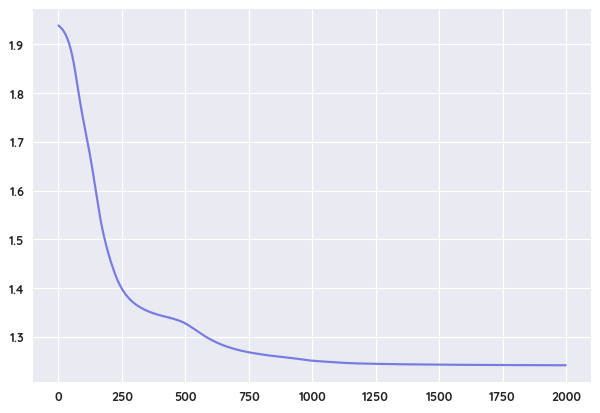

In [13]:
plt.plot(losses)

In [14]:
def generate_sentence(model, start_word, end_word, max_length=100):
    next_word = start_word
    x = torch.tensor([next_word]).unsqueeze(0)
    i = 0
    while next_word != end_word and i < max_length:
        probs = model(x)[0][-1]
        next_word = Categorical(probs).sample()
        x = torch.cat([x, torch.tensor([next_word]).unsqueeze(-1)], dim=-1)
        i += 1
    return x[0]

In [15]:
[generate_sentence(model, special_words["start"], special_words["end"]).tolist() for _ in range(20)]

[[0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 6, 5, 4, 3, 2, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1],
 [0, 2, 3, 4, 5, 6, 1]]